# Determine Most Differential CellProfiler Features
This analysis aims to identify the most differential features between target GOLD images and the Cross Zamirski generated GOLD images.

In [1]:
import pathlib
from collections import defaultdict

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from scipy.stats import wasserstein_distance

## Inputs

In [2]:
morphology_data_path = pathlib.Path("analysis_output_nuclear_speckle").resolve(
    strict=True
)

gen_featuredf = pd.read_csv(
    morphology_data_path / "gold_generated_images_output/Image.csv"
)
target_featuredf = pd.read_csv(
    morphology_data_path / "gold_target_images_output/Image.csv"
)

## Outputs

In [3]:
figure_path = pathlib.Path("figures")
figure_path.mkdir(parents=True, exist_ok=True)

comparison_data_path = pathlib.Path("comparison_data")
comparison_data_path.mkdir(parents=True, exist_ok=True)

## Filter by Column

In [4]:
metadata_types = ["Metadata", "ExecutionTime", "ModuleError"]
feature_types = ["ImageQuality", "Intensity", "Granularity", "Texture"]
print(len(gen_featuredf.columns.tolist()))

gen_featuredf = gen_featuredf.drop(
    columns=gen_featuredf.columns[
        gen_featuredf.columns.str.contains("|".join(metadata_types), case=False)
    ]
)

gen_featuredf = gen_featuredf[
    gen_featuredf.columns[
        gen_featuredf.columns.str.contains("|".join(feature_types), case=False)
    ]
]

target_featuredf = target_featuredf.drop(
    columns=target_featuredf.columns[
        target_featuredf.columns.str.contains("|".join(metadata_types), case=False)
    ]
)

target_featuredf = target_featuredf[
    target_featuredf.columns[
        target_featuredf.columns.str.contains("|".join(feature_types), case=False)
    ]
]

124


# Compute Symmetric Wasserstein Feature Distances

In [5]:
feature_similaritiesdf = defaultdict(list)

for cp_column in target_featuredf.columns:
    first_dist = wasserstein_distance(
        gen_featuredf[cp_column], target_featuredf[cp_column]
    )
    second_dist = wasserstein_distance(
        target_featuredf[cp_column], gen_featuredf[cp_column]
    )
    feature_similaritiesdf["symmetric_wasserstein_distance"].append(
        (first_dist + second_dist) / 2
    )
    feature_similaritiesdf["cp_feature"].append(cp_column)

feature_similaritiesdf = pd.DataFrame(feature_similaritiesdf).sort_values(
    by="symmetric_wasserstein_distance", ascending=True
)

feature_similaritiesdf.to_parquet(
    comparison_data_path / "wasserstein_feature_similarities.parquet"
)

## Show Feature Similarities

In [6]:
print(feature_similaritiesdf.head())

    symmetric_wasserstein_distance                                cp_feature
20                    0.000000e+00              ImageQuality_Scaling_sc_crop
29                    0.000000e+00               Intensity_TotalArea_sc_crop
26                    7.497444e-07            Intensity_MinIntensity_sc_crop
21                    7.469596e-05  Intensity_LowerQuartileIntensity_sc_crop
27                    8.638742e-05          Intensity_PercentMaximal_sc_crop


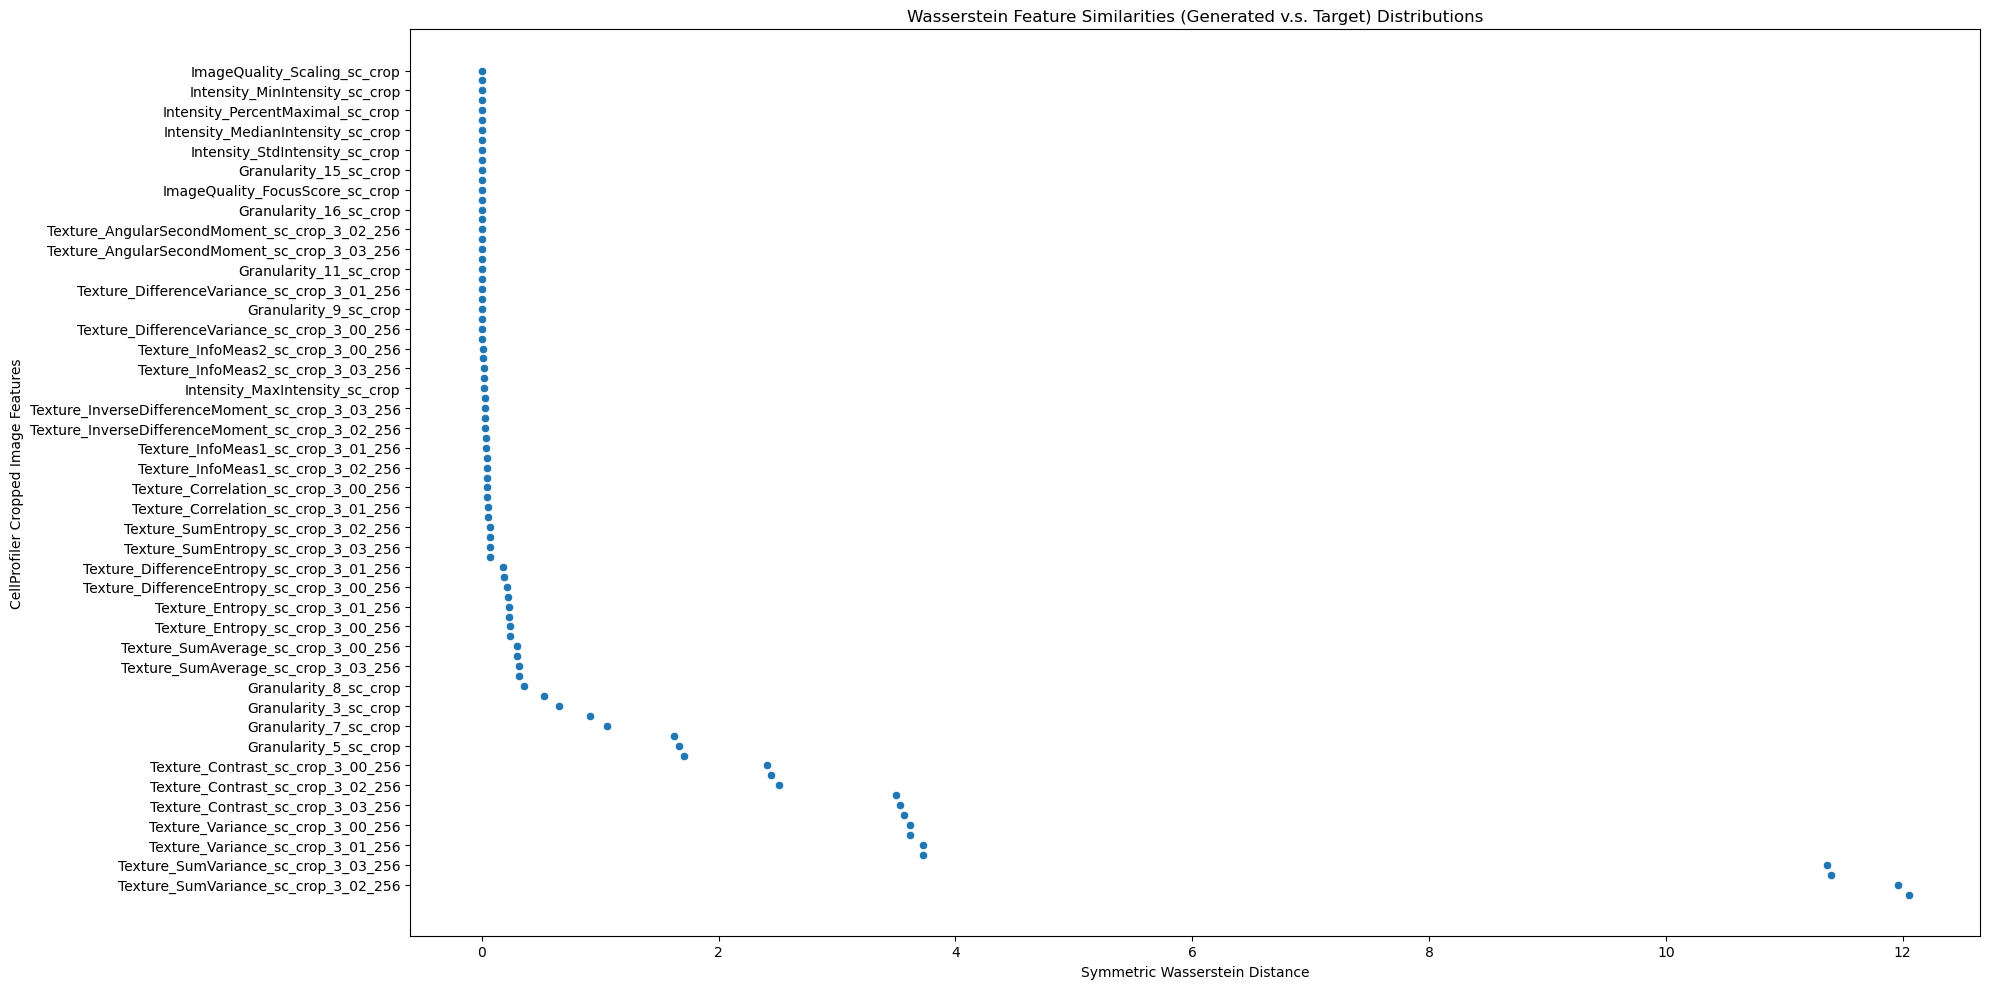

In [7]:
plt.figure(figsize=(20, 10))
sns.scatterplot(
    x="symmetric_wasserstein_distance", y="cp_feature", data=feature_similaritiesdf
)

plt.ylabel("CellProfiler Cropped Image Features")
plt.xlabel("Symmetric Wasserstein Distance")

plt.title("Wasserstein Feature Similarities (Generated v.s. Target) Distributions")
yticks = plt.gca().get_yticks()
plt.yticks(yticks[::2])
plt.tight_layout()
plt.savefig(figure_path / "wasserstein_feature_similarity.png")